In [1]:
# import packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from utils import convert_pvalue_to_asterisks

In [2]:
def load_data(data_path):
    corr_train = np.load(os.path.join(data_path, 'corr.npy')).flatten()
    corr_test = np.load(os.path.join(data_path, 'corr_test.npy'))
    corr_test_valid = corr_test[~np.isnan(corr_test)]
    # print(f'mean train = {np.mean(corr_train):.3f}, test = {np.mean(corr_test_valid):.3f}')
    return corr_train, corr_test_valid

def compute_pvalue(data_dict):
    vae = np.hstack(data_dict['VAE'])
    ppca = np.hstack(data_dict['PPCA'])
    ivae = np.hstack(data_dict['iVAE'])
    n_sample = len(vae)
    stat_vae_ppca = wilcoxon(vae, ppca, alternative='greater')
    stat_vae_ivae = wilcoxon(vae, ivae, alternative='greater')
    return [stat_vae_ppca.pvalue*n_sample, stat_vae_ivae.pvalue*n_sample]

def plot_boxviolin(df, axis, title, pvalue=None):
    palette = [sns.color_palette("Set2")[i] for i in [1,0,2]]

    sns.set_style("whitegrid")
    ax = sns.violinplot(data=df,
                        saturation=1,
                        dodge=False,
                        palette=palette,
                        density_norm='width',
                        inner=None,
                        ax=axis)
    # plt.setp(ax.collections, alpha=.8)
    xlim = ax.get_xlim()
    ylim = [0.3, 1.1]
    for violin in ax.collections:
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))
    sns.boxplot(data=df, saturation=1, showfliers=False,
                width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
    old_len_collections = len(ax.collections)
    sns.stripplot(data=df, palette=palette, dodge=False, size=1.5, ax=ax)
    for dots in ax.collections[old_len_collections:]:
        dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))

    x1, x2, x3 = 0, 1, 2
    y1, y2, h, col = 1+0.04, 0.975, 0.01, 'k'
    ax.plot([x1, x1, x2, x2], [y2, y2+h, y2+h, y2], lw=1.2, c=col)
    ax.text((x1+x2)*.5, y2+h*.1, convert_pvalue_to_asterisks(pvalue[0]), ha='center', va='bottom', color=col)
    ax.plot([x1, x1, x3, x3], [y1, y1+h, y1+h, y1], lw=1.2, c=col)
    ax.text((x1+x3)*.5, y1+h*.1, convert_pvalue_to_asterisks(pvalue[1]), ha='center', va='bottom', color=col)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['VAE', 'PPCA', 'iVAE'], fontsize=11)
    ax.set_xlabel('Method', fontsize=11)
    ax.set_ylabel('Pearson correlation', fontsize=11)
    ax.set_title(title, fontweight='bold', fontsize=14)

In [3]:
# load dataset
data_path = '/data/users4/xli/interpolation/results'
dict_sz_train = {'VAE': [], 'PPCA': [], 'iVAE': []}
dict_sz_test = {'VAE': [], 'PPCA': [], 'iVAE': []}
dict_asd_train = {'VAE': [], 'PPCA': [], 'iVAE': []}
dict_asd_test = {'VAE': [], 'PPCA': [], 'iVAE': []}

for method in ['VAE', 'PPCA', 'iVAE']:
    for seed in range(10):
        # SZ
        if method == 'iVAE':
            res_path = os.path.join(data_path, 'sfnc_sz', method.lower(), 'hypopt', f'layer3_dim16_seed{seed}')
        elif method == 'VAE':
            res_path = os.path.join(data_path, 'sfnc_sz', method.lower(), 'hypopt', 'layer3', f'seed{seed}')   
        else:
            res_path = os.path.join(data_path, 'sfnc_sz', method.lower(), 'hypopt', f'seed{seed}')
        corr_train, corr_test = load_data(res_path)
        dict_sz_train[method] += list(corr_train)
        dict_sz_test[method] += list(corr_test)
        
        # ASD
        if method == 'iVAE':
            res_path = os.path.join(data_path, 'sfnc_asd', method.lower(), 'hypopt', f'layer2_dim32_seed{seed}')
        elif method == 'VAE':
            res_path = os.path.join(data_path, 'sfnc_asd', method.lower(), 'hypopt', 'layer2', f'seed{seed}')   
        else:
            res_path = os.path.join(data_path, 'sfnc_asd', method.lower(), 'hypopt', f'seed{seed}')
        corr_train, corr_test = load_data(res_path)
        dict_asd_train[method] += list(corr_train)
        dict_asd_test[method] += list(corr_test)

df_sz_train = pd.DataFrame.from_dict(dict_sz_train)
df_sz_test = pd.DataFrame.from_dict(dict_sz_test)
df_asd_train = pd.DataFrame.from_dict(dict_asd_train)
df_asd_test = pd.DataFrame.from_dict(dict_asd_test)

pvalue_sz_train = compute_pvalue(df_sz_train)
pvalue_sz_test = compute_pvalue(df_sz_test)
pvalue_asd_train = compute_pvalue(df_asd_train)
pvalue_asd_test = compute_pvalue(df_asd_test)

print(df_sz_test.mean()) 
print(df_asd_test.mean())

VAE     0.765303
PPCA    0.710808
iVAE    0.740887
dtype: float64
VAE     0.724196
PPCA    0.694210
iVAE    0.708206
dtype: float64


/tmp/ipykernel_2477598/1881793569.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['VAE', 'PPCA', 'iVAE'], fontsize=11)
/tmp/ipykernel_2477598/1881793569.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['VAE', 'PPCA', 'iVAE'], fontsize=11)


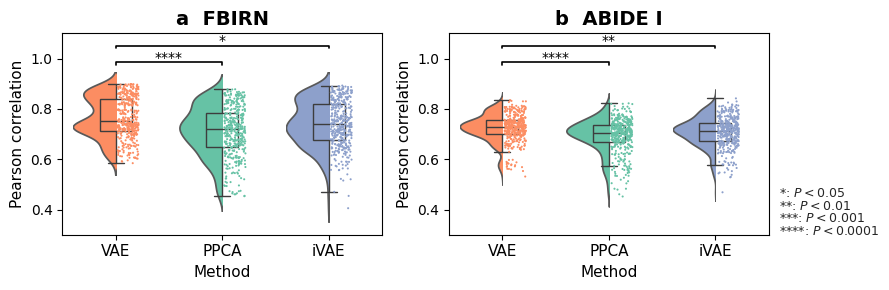

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
plot_boxviolin(df_sz_test, axes[0], "a  FBIRN", pvalue_sz_test)
plot_boxviolin(df_asd_test, axes[1], "b  ABIDE I", pvalue_asd_test)
plt.text(2.6, 0.45, "*: $P<0.05$", fontsize=9)
plt.text(2.6, 0.4, "**: $P<0.01$", fontsize=9)
plt.text(2.6, 0.35, "***: $P<0.001$", fontsize=9)
plt.text(2.6, 0.3, "****: $P<0.0001$", fontsize=9)
plt.tight_layout()
plt.savefig('baseline_comparison.pdf')